# Overturning streamfunction

integral of ty_trans_rho  = zonal integral of vhrho

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:38049' processes=4 threads=8, memory=32.00 GiB>

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
expt = '01deg_jra55v13_ryf9091'
# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 1.54 s, sys: 262 ms, total: 1.8 s
Wall time: 12.8 s


In [10]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


CPU times: user 140 ms, sys: 33.2 ms, total: 173 ms
Wall time: 341 ms


In [7]:
pot_rho_1 = cc.querying.getvar(expt,'pot_rho_1',session,start_time = '2170-01-01',end_time = '2179-12-31')
pot_rho_1 = pot_rho_1.sel(yt_ocean = lat_range)
pot_rho_1 = pot_rho_1.sel(time = slice('2170-01-01','2179-12-31'))


In [8]:
pot_rho_1_month = pot_rho_1.isel(st_ocean = 0).groupby("time.month").mean('time')
pot_rho_1_Sep = pot_rho_1_month.isel(month = 9)

open meridional transport data

In [9]:
path = '/g/data/x77/cy8964/Post_Process/New_SO/Paper_Data/'
h_binned_bar = xr.open_dataset(path+'h_bar_10yr.nc').h_bar
vh_binned_bar = xr.open_dataset(path+'vh_bar_10yr.nc').vh_bar
v_binned_bar = xr.open_dataset(path+'v_bar_10yr.nc').v_bar

break into residual, mean and eddy components

In [11]:
%%time
residual = (vh_binned_bar*dxt).sum('xt_ocean')
residual = residual/rho_0/1e6
mean = (v_binned_bar*h_binned_bar*dxt).sum('xt_ocean')
mean = mean/1e6
eddy = residual - mean


CPU times: user 447 ms, sys: 1.94 s, total: 2.39 s
Wall time: 4.09 s


In [15]:
isopycnal_depth = h_binned_bar.where(h_binned_bar !=0).cumsum('isopycnal_bins').mean('xt_ocean')

this function is useful for finding streamfunction from meridional transport

In [12]:
def cumsum_from_bottom (residual):
    cumsum= (residual.cumsum('isopycnal_bins')-residual.sum('isopycnal_bins'))
    return cumsum


In [13]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13})

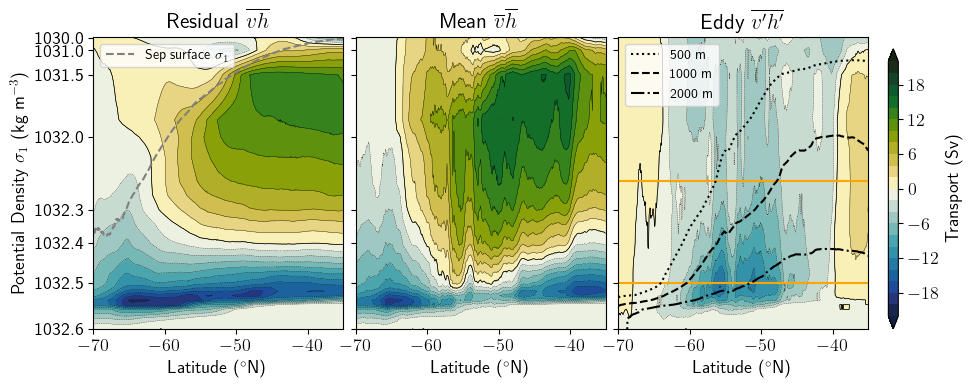

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4), sharey = True)

clev = np.arange(-22,23,2)
yticks = np.array([1030,1031,1031.5, 1032, 1032.3,1032.4,1032.5,1032.6,1032.8])
scfac = 13  ## A power to set teh stretching
p1=axes[0].contourf(residual.yt_ocean,(residual.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(residual.sel(isopycnal_bins = slice(1025,1033))), cmap=cm.cm.delta, levels=clev, extend='both')
axes[0].contour(residual.yt_ocean,(residual.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(residual.sel(isopycnal_bins = slice(1025,1033))), levels=clev, colors='k', linewidths=0.25)
axes[0].contour(residual.yt_ocean,(residual.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(residual.sel(isopycnal_bins = slice(1025,1033))), levels=[0.0,], colors='k', linewidths=0.5)

axes[0].set_yticks((yticks-1025)**scfac)
axes[0].set_yticklabels(yticks)
axes[0].set_ylim([0.1**scfac, 7.6**scfac])
axes[0].invert_yaxis()
axes[0].set_ylabel('Potential Density $\sigma_1$ (kg m$^{-3}$)')
axes[0].set_xlabel('Latitude ($^\circ$N)')
axes[0].set_xlim([-70,-35])
axes[0].plot(yt_ocean.values, (pot_rho_1_Sep.mean('xt_ocean').values-1025)**scfac,color = 'grey', label = 'Sep surface $\sigma_1$', linestyle = '--')
axes[0].legend(fontsize = 10)

axes[1].contourf(mean.yt_ocean,(mean.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(mean.sel(isopycnal_bins = slice(1025,1033))), cmap=cm.cm.delta, levels=clev, extend='both')
axes[1].contour(mean.yt_ocean,(mean.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(mean.sel(isopycnal_bins = slice(1025,1033))), levels=clev, colors='k', linewidths=0.25)
axes[1].contour(mean.yt_ocean,(mean.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(mean.sel(isopycnal_bins = slice(1025,1033))), levels=[0.0,], colors='k', linewidths=0.5)

axes[1].set_xlabel('Latitude ($^\circ$N)')
axes[1].set_xlim([-70,-35])

axes[2].contourf(eddy.yt_ocean,(eddy.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(eddy.sel(isopycnal_bins = slice(1025,1033))), cmap=cm.cm.delta, levels=clev, extend='both')
axes[2].contour(eddy.yt_ocean,(eddy.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(eddy.sel(isopycnal_bins = slice(1025,1033))), levels=clev, colors='k', linewidths=0.25)
axes[2].contour(eddy.yt_ocean,(eddy.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, cumsum_from_bottom(eddy.sel(isopycnal_bins = slice(1025,1033))), levels=[0.0,], colors='k', linewidths=0.5)

axes[2].set_xlabel('Latitude ($^\circ$N)')
axes[2].set_xlim([-70,-35])
axes[2].hlines(7.5**scfac,-70,-35,color = 'orange', linestyle = '-')
axes[2].hlines(7.2**scfac,-70,-35,color = 'orange', linestyle = '-')
cs = axes[2].contour(isopycnal_depth.yt_ocean, (isopycnal_depth.sel(isopycnal_bins = slice(1025,1033)).isopycnal_bins-1025)**scfac, isopycnal_depth.sel(isopycnal_bins = slice(1025,1033)), levels = [500,1000,2000], colors = 'k', linestyles = ['dotted','--','-.'])

labels = ['500 m','1000 m','2000 m']
for i in range(len(labels)):
    cs.collections[i].set_label(labels[i])
axes[2].legend(loc='upper left', fontsize = 10)


axes[0].set_title('Residual $\overline{vh}$');
axes[1].set_title('Mean $\overline{v}\overline{h}$');
axes[2].set_title('Eddy $\overline{v\'h\'}$');

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Transport (Sv)')
plt.subplots_adjust(wspace =0.05, bottom = 0.15)

fig.savefig('Fig5-overturning_sigma1.png', dpi = 400)